In [ ]:
!pip install dnspython
!pip install colab-env --upgrade

Requirement already up-to-date: colab-env in /usr/local/lib/python3.7/dist-packages (0.2.0)


In [ ]:
from pymongo import MongoClient
import pandas as pd
import colab_env
import os
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow as tf

DB_STRING = os.getenv('DB_STRING')

client = MongoClient(DB_STRING)
db = client.tweets

Mounted at /content/gdrive


In [ ]:
themes = [
    'politics',
    'education',
    'programming',
    'anime',
    'manga',
    'food',
    'smoking',
    'motivation',
    'blm',
    'crypto',
    'football',
    'voleyball',
    'comics',
    'beauty',
    'friends',
    'alcohol',
    'deeplearning',
    'fitness',
    'funny',
    'travel'
]

In [ ]:
dataset = pd.DataFrame(columns=['text', 'target'])
themed_tweets = {}

for theme in themes:
  collection = db[theme]
  themed_data = pd.DataFrame(list(collection.find()))
  themed_data = themed_data.drop('_id', axis=1)
  themed_tweets[theme] = themed_data.copy()
  themed_data['target'] = theme
  dataset = dataset.append(themed_data)

dataset = dataset.sample(frac=1) 
dataset.head()

,text,target
2670,Ahahaha its not funny but Im giggling cuz we s...,funny
2488,Two months alcohol free this week,alcohol
1916,are absurd &amp; thin stuff. A serious imbiber...,alcohol
1119,"Heres to alcohol, the rose-colored glasses of ...",alcohol
2846,I used to smoke and I found that smoking has a...,smoking


In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [ ]:
embed = hub.load(module_url)
embeddings_array = []

for theme in themes:
  theme_embeddings = np.average(embed(themed_tweets[theme]['text']),axis = 0)
  embeddings_array.append(theme_embeddings)

np.shape(embeddings_array)

(20, 20)

In [ ]:
def compute_pca(X, n_components=2):
    X_demeaned = X - np.mean(X, axis=0)

    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar = False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO = 'L')

    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)

    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]

    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]
    
    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,:n_components]

    # transform the data by multiplying the transpose of the eigenvectors 
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = (np.dot(eigen_vecs_subset.T, X_demeaned.T)).T

    ### END CODE HERE ###

    return X_reduced

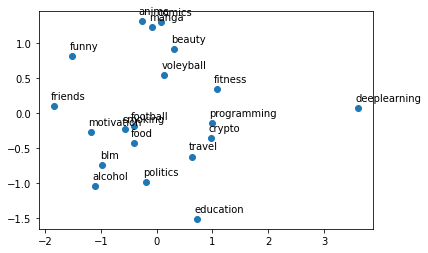

In [ ]:
result = compute_pca(embeddings_array, n_components=2)

plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(themes):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))

plt.show()


In [ ]:
dataset['target'] = dataset['target'].apply(lambda val: themes.index(val)) 
dataset.head()

,text,target
2670,Ahahaha its not funny but Im giggling cuz we s...,18
2488,Two months alcohol free this week,15
1916,are absurd &amp; thin stuff. A serious imbiber...,15
1119,"Heres to alcohol, the rose-colored glasses of ...",15
2846,I used to smoke and I found that smoking has a...,6


In [ ]:
dataset_len = len(dataset)
print(dataset_len)

train_part = 0.8
train, test = np.split(dataset, [int(train_part*dataset_len)])

print(len(train))
print(len(test))

54096
43276
10820


In [ ]:
def create_model():

  hub_layer=hub.KerasLayer(module_url, input_shape=[], output_shape=[20], dtype=tf.string, trainable=False)

  model = tf.keras.models.Sequential([
      hub_layer,
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(20)                                    
    ])
  
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  return model

In [ ]:
model = create_model()


In [ ]:
history = model.fit(
    train['text'], 
    train['target'], 
    epochs=50,
    batch_size=32,
    validation_data=(test['text'], test['target']),
)

Epoch 1/50
1353/1353 [==============================] - 4s 3ms/step - loss: 2.1600 - accuracy: 0.3356 - val_loss: 1.7404 - val_accuracy: 0.4565
Epoch 2/50
1353/1353 [==============================] - 3s 3ms/step - loss: 1.7308 - accuracy: 0.4696 - val_loss: 1.6969 - val_accuracy: 0.4811
Epoch 3/50
1353/1353 [==============================] - 3s 3ms/step - loss: 1.6937 - accuracy: 0.4789 - val_loss: 1.6761 - val_accuracy: 0.4799
Epoch 4/50
1353/1353 [==============================] - 3s 2ms/step - loss: 1.6561 - accuracy: 0.4927 - val_loss: 1.6571 - val_accuracy: 0.4897
Epoch 5/50
1353/1353 [==============================] - 3s 2ms/step - loss: 1.6319 - accuracy: 0.4954 - val_loss: 1.6473 - val_accuracy: 0.4913
Epoch 6/50
1353/1353 [==============================] - 3s 3ms/step - loss: 1.6152 - accuracy: 0.5029 - val_loss: 1.6230 - val_accuracy: 0.4977
Epoch 7/50
1353/1353 [==============================] - 3s 3ms/step - loss: 1.6142 - accuracy: 0.5035 - val_loss: 1.6171 - val_accuracy:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

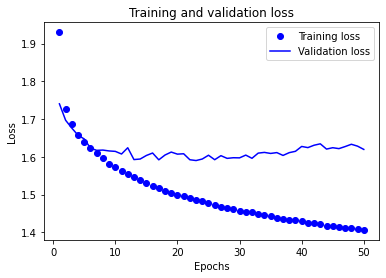

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

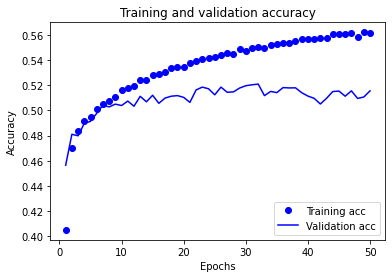

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model = create_model()

model.fit(
    train['text'], 
    train['target'], 
    epochs=10,
    batch_size=32,
    validation_data=(test['text'], test['target']),
)

Epoch 1/10
1353/1353 [==============================] - 4s 3ms/step - loss: 2.1529 - accuracy: 0.3420 - val_loss: 1.7419 - val_accuracy: 0.4654
Epoch 2/10
1353/1353 [==============================] - 3s 2ms/step - loss: 1.7472 - accuracy: 0.4674 - val_loss: 1.6825 - val_accuracy: 0.4813
Epoch 3/10
1353/1353 [==============================] - 3s 2ms/step - loss: 1.6856 - accuracy: 0.4842 - val_loss: 1.6507 - val_accuracy: 0.4920
Epoch 4/10
1353/1353 [==============================] - 3s 2ms/step - loss: 1.6706 - accuracy: 0.4864 - val_loss: 1.6719 - val_accuracy: 0.4882
Epoch 5/10
1353/1353 [==============================] - 3s 2ms/step - loss: 1.6483 - accuracy: 0.4963 - val_loss: 1.6312 - val_accuracy: 0.4985
Epoch 6/10
1353/1353 [==============================] - 3s 2ms/step - loss: 1.6195 - accuracy: 0.5016 - val_loss: 1.6291 - val_accuracy: 0.4999
Epoch 7/10
1353/1353 [==============================] - 3s 2ms/step - loss: 1.6017 - accuracy: 0.5063 - val_loss: 1.6098 - val_accuracy:

In [ ]:
model.save('saved_model/my_h5_model.h5')

NameError: ignored

In [ ]:
save_path = 'trained_model.ckpt'

In [ ]:
model.save_weights(save_path)

In [ ]:
restored_model = create_model()

In [ ]:
restored_model.load_weights(save_path)

NotFoundError: ignored

In [ ]:
restored_model.evaluate(test['text'], test['target'])

339/339 [==============================] - 1s 1ms/step - loss: 1.6365 - accuracy: 0.5101


[1.6196348667144775, 0.5155268311500549]

In [ ]:
new_model = create_model()
new_model.load_weights('/content/my_h5_model.h5')

new_model.predict(['i like anime'])

array([[-4.0853114 , -5.996764  , -0.9963024 ,  5.3889675 ,  5.8631144 ,
        -1.5224459 , -3.1300104 , -2.9317698 , -4.1298614 , -2.985921  ,
        -4.2055984 , -3.6933894 ,  1.6867087 , -0.25840282, -4.8462996 ,
        -3.5583968 , -5.4224243 , -1.2960075 ,  2.417191  , -0.0571719 ]],
      dtype=float32)